<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing image: /content/1(1).png


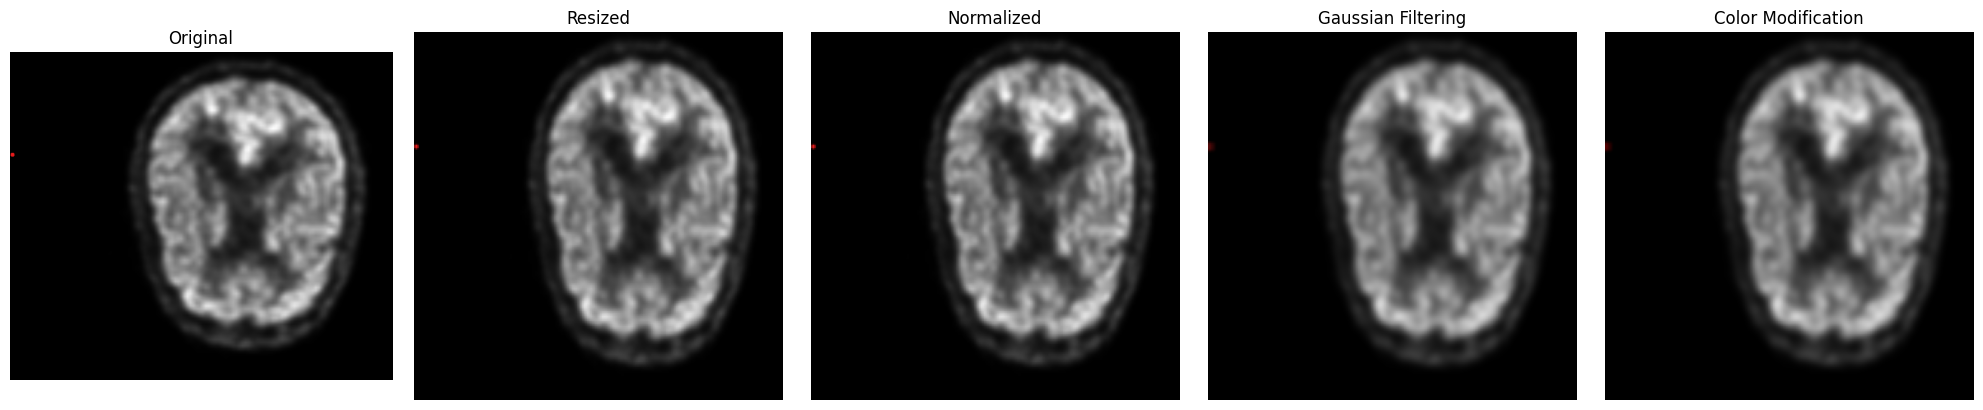

Preprocessing complete! Image processed and saved to /content/preprocessed_images
Processed image saved as: /content/preprocessed_images/1(1).png

You can download the processed image with:
from google.colab import files
files.download('/content/preprocessed_images/1(1).png')


In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Define the specific image file path and output directory
IMAGE_PATH = '/content/1(1).png'  # The specific image file
OUTPUT_PATH = '/content/preprocessed_images'

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

def preprocess_image(image_path, output_path):
    """
    Apply preprocessing steps to an image:
    1. Data Resize
    2. Normalization
    3. Gaussian Filtering
    4. Color Modification
    """
    # Read the image
    img = cv2.imread(image_path)

    # Check if image was successfully loaded
    if img is None:
        print(f"Could not read image: {image_path}")
        return None

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Step 1: Data Resize - resize to 224x224 (standard size for many CNN models)
    img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)

    # Step 2: Normalization - scale pixel values to range [0,1]
    img_normalized = img_resized.astype(np.float32) / 255.0

    # Step 3: Gaussian Filtering - apply Gaussian blur
    img_blurred = cv2.GaussianBlur(img_normalized, (5, 5), 5)

    # Step 4: Color Modification - enhance contrast
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2HSV)
    # Increase saturation
    img_hsv[:, :, 1] = img_hsv[:, :, 1] * 1.2
    # Clip values to valid range
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 12.0)
    # Convert back to RGB
    img_enhanced = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    # Convert back to uint8 for saving
    img_final = (img_enhanced * 255).astype(np.uint8)

    # Save the processed image
    output_file = os.path.join(output_path, os.path.basename(image_path))
    cv2.imwrite(output_file, cv2.cvtColor(img_final, cv2.COLOR_RGB2BGR))

    return {
        'original': img,
        'resized': img_resized,
        'normalized': img_normalized,
        'blurred': img_blurred,
        'enhanced': img_enhanced
    }

def display_preprocessing_steps(image_dict):
    """
    Display all preprocessing steps for a single image
    """
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))

    axs[0].imshow(image_dict['original'])
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(image_dict['resized'])
    axs[1].set_title('Resized')
    axs[1].axis('off')

    axs[2].imshow(image_dict['normalized'])
    axs[2].set_title('Normalized')
    axs[2].axis('off')

    axs[3].imshow(image_dict['blurred'])
    axs[3].set_title('Gaussian Filtering')
    axs[3].axis('off')

    axs[4].imshow(image_dict['enhanced'])
    axs[4].set_title('Color Modification')
    axs[4].axis('off')

    plt.tight_layout()
    plt.show()

# Process the specific image
def process_image():
    print(f"Processing image: {IMAGE_PATH}")

    # Check if the file exists
    if not os.path.exists(IMAGE_PATH):
        print(f"Error: The file {IMAGE_PATH} does not exist.")
        return

    # Process the image
    preprocessing_results = preprocess_image(IMAGE_PATH, OUTPUT_PATH)

    if preprocessing_results:
        display_preprocessing_steps(preprocessing_results)

        print(f"Preprocessing complete! Image processed and saved to {OUTPUT_PATH}")

        # Show the path to the output file
        output_file = os.path.join(OUTPUT_PATH, os.path.basename(IMAGE_PATH))
        print(f"Processed image saved as: {output_file}")

        # Allow user to download the processed image
        print("\nYou can download the processed image with:")
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")
    else:
        print("Failed to process the image. Please check the image format and path.")

# Run the processing
process_image()

In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from einops import rearrange

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Preprocessing functions
def preprocess_image(image_path):
    """
    Apply preprocessing steps to an image:
    1. Data Resize
    2. Normalization
    3. Gaussian Filtering
    4. Color Modification
    """
    # Read the image
    img = cv2.imread(image_path)

    # Check if image was successfully loaded
    if img is None:
        print(f"Could not read image: {image_path}")
        return None

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Step 1: Data Resize - resize to 256x256 (appropriate for medical image segmentation)
    img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

    # Step 2: Normalization - scale pixel values to range [0,1]
    img_normalized = img_resized.astype(np.float32) / 255.0

    # Step 3: Gaussian Filtering - apply Gaussian blur
    img_blurred = cv2.GaussianBlur(img_normalized, (5, 5), 0)

    # Step 4: Color Modification - enhance contrast
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2HSV)
    # Increase saturation
    img_hsv[:, :, 1] = img_hsv[:, :, 1] * 1.2
    # Clip values to valid range
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 1.0)
    # Convert back to RGB
    img_enhanced = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    # Convert to grayscale if it's a medical scan (which often are grayscale)
    if np.allclose(img_enhanced[:,:,0], img_enhanced[:,:,1]) and np.allclose(img_enhanced[:,:,1], img_enhanced[:,:,2]):
        img_final = img_enhanced[:,:,0]
        # Add channel dimension for model input
        img_final = np.expand_dims(img_final, axis=0)
    else:
        # Use all three channels and transpose to channel-first format (C, H, W)
        img_final = np.transpose(img_enhanced, (2, 0, 1))

    return img_final, img_resized  # Return both the processed tensor and the resized original for visualization

# Multi-head Self-Attention (MSA) module
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

# Transformer Layer
class TransformerLayer(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# CNN Encoder Block
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        skip = x  # Store for skip connection
        x = self.maxpool(x)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)  # Ensure correct input channels
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, skip):
        x = self.upconv(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((skip, x), dim=1)  # Concatenating along the channel dimension
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

# TranUNet Model
class TranUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, embed_dim=256, patch_size=16, num_heads=8, num_transformer_layers=12):
        super(TranUNet, self).__init__()

        # CNN Encoder
        self.enc1 = CNNBlock(in_channels, 64)
        self.enc2 = CNNBlock(64, 128)
        self.enc3 = CNNBlock(128, 256)
        self.enc4 = CNNBlock(256, 512)

        # Linear projection
        self.patch_size = patch_size
        self.linear_proj = nn.Linear(patch_size * patch_size * 512, embed_dim)

        # Transformer Layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(dim=embed_dim, num_heads=num_heads)
            for _ in range(num_transformer_layers)
        ])

        # Reshape and CNN decoder
        self.dec1 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec3 = DecoderBlock(128, 64)
        self.dec4 = nn.Conv2d(64, out_channels, kernel_size=1)

        # Final activation
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Store dimensions
        B, C, H, W = x.shape

        # Encoder
        x, skip1 = self.enc1(x)        # 1/2
        x, skip2 = self.enc2(x)        # 1/4
        x, skip3 = self.enc3(x)        # 1/8
        x, skip4 = self.enc4(x)        # 1/16

        # Prepare for transformer
        # Original:
        # x_patches = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
        #                      p1=self.patch_size, p2=self.patch_size)
        # Change to:
        # Calculate H_patch and W_patch to ensure divisibility by patch_size
        H_patch = (x.shape[2] + self.patch_size - 1) // self.patch_size
        W_patch = (x.shape[3] + self.patch_size - 1) // self.patch_size

        # Pad the input if necessary to make it divisible by patch_size
        pad_h = H_patch * self.patch_size - x.shape[2]
        pad_w = W_patch * self.patch_size - x.shape[3]
        x = F.pad(x, (0, pad_w, 0, pad_h)) # pad the input

        x_patches = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                             p1=self.patch_size, p2=self.patch_size)

        x = self.linear_proj(x_patches)


        # Transformer layers
        for layer in self.transformer_layers:
            x = layer(x)

        # Reshape back for decoder
        # Original:
        # x = rearrange(x, 'b (h w) c -> b c h w',
        #               h=H // self.patch_size, w=W // self.patch_size)
        # Change to:
        x = rearrange(x, 'b (h w) c -> b c h w',
                      h=H_patch, w=W_patch)# Reshape using calculated H_patch and W_patch

        # Decoder with skip connections
        x = self.dec1(x, skip4)  # This line was incorrectly indented
        x = self.dec2(x, skip3)
        x = self.dec3(x, skip2)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        x = self.dec4(x)

        # Final activation
        x = self.final_activation(x)

        return x

# Function to segment an image with TranUNet model
def segment_image(model, image_path, output_path=None):
    """
    Segment an image using the TranUNet model
    """
    # Preprocess the image
    processed_img, original_img = preprocess_image(image_path)

    # Convert to PyTorch tensor
    img_tensor = torch.FloatTensor(processed_img).unsqueeze(0).to(device)

    # Perform segmentation
    with torch.no_grad():
        model.eval()
        segmentation = model(img_tensor)
        segmentation = segmentation.squeeze().cpu().numpy()

    # Visualize and save results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    if len(processed_img.shape) == 3:  # RGB image
        plt.imshow(np.transpose(processed_img, (1, 2, 0)))
    else:  # Grayscale image
        plt.imshow(processed_img[0], cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmentation, cmap='viridis')
    plt.title('Segmentation Result')
    plt.axis('off')

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path)
        print(f"Segmentation result saved to {output_path}")

    plt.show()

    return segmentation

# Main function to run the model
def main():
    # Set the image path
    image_path = '/content/1(1).png'  # Update this to your image path
    output_path = '/content/segmentation_result.png'

    # Initialize the model
    model = TranUNet(in_channels=3, out_channels=1).to(device)

    # Print model summary
    print(model)

    # For a real application, we would load pre-trained weights:
    # model.load_state_dict(torch.load('tranunet_weights.pth'))

    # In this demo, we'll use a randomly initialized model
    print("Note: Using a randomly initialized model for demonstration. In practice, you would need a trained model.")

    # Segment the image
    segmentation = segment_image(model, image_path, output_path)

    return segmentation

if __name__ == "__main__":
    main()

Using device: cpu
TranUNet(
  (enc1): CNNBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): CNNBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

RuntimeError: Given transposed=1, weight of size [512, 256, 2, 2], expected input[1, 256, 1, 1] to have 512 channels, but got 256 channels instead